In [45]:
import yfinance as yf

sp500 = yf.Ticker("^GSPC")

sp500 = sp500.history(period="max")

sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-26 00:00:00-04:00,5639.660156,5651.620117,5602.339844,5616.839844,2938570000,0.0,0.0
2024-08-27 00:00:00-04:00,5602.890137,5631.180176,5593.479980,5625.799805,2798990000,0.0,0.0
2024-08-28 00:00:00-04:00,5624.509766,5627.029785,5560.950195,5592.180176,3053450000,0.0,0.0


In [46]:
del sp500['Dividends']
del sp500['Stock Splits']

sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-08-19 00:00:00-04:00', '2024-08-20 00:00:00-04:00',
               '2024-08-21 00:00:00-04:00', '2024-08-22 00:00:00-04:00',
               '2024-08-23 00:00:00-04:00', '2024-08-26 00:00:00-04:00',
               '2024-08-27 00:00:00-04:00', '2024-08-28 00:00:00-04:00',
               '2024-08-29 00:00:00-04:00', '2024-08-30 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24283, freq=None)

<Axes: title={'center': 'S&P 500'}, xlabel='Date', ylabel='Price'>

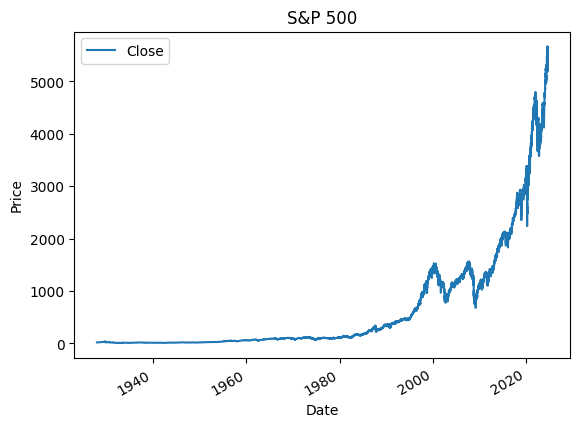

In [47]:
sp500.plot.line(y='Close', title='S&P 500', ylabel='Price', xlabel='Date')

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)



In [8]:
sp500 = sp500.loc["1990-01-01":].copy()


In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,min_samples_split = 100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Open", "High", "Low", "Close", "Volume"]

model.fit(train[predictors], train["Target"])


RandomForestClassifier(min_samples_split=100, random_state=1)

In [29]:
from sklearn.metrics import precision_score
import pandas as pd


predictions = model.predict(test[predictors])
predictions = pd.Series(predictions, index=test.index)

precision_score(test["Target"], predictions).round(4)


np.float64(0.5333)

In [30]:
combined = pd.concat([test["Target"], predictions], axis = 1)



In [32]:
def predict(train,test,model,predictors):

    model.fit(train[predictors], train["Target"])
    predictions = model.predict(test[predictors])
    predictions = pd.Series(predictions, index=test.index, name = "Predictions")
    combined = pd.concat([test["Target"], predictions], axis = 1)

    return combined


In [33]:
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, model, predictors)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)


predictions = backtest(sp500, model, predictors)

In [34]:
predictions["Predictions"].value_counts()

Predictions
0    3613
1    2620
Name: count, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"]).round(4)

np.float64(0.524)

In [38]:
horizons = [2, 5, 10, 60, 250, 1000]
new_predictors = [] 

for horizon in horizons:
    rolling_average = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_average["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]


sp500 = sp500.dropna()

In [40]:
model = RandomForestClassifier(n_estimators=200,min_samples_split = 50 , random_state=1)


In [41]:
def predict(train,test,model,predictors):

    model.fit(train[predictors], train["Target"])
    predictions = model.predict_proba(test[predictors])[:,1]
    predictions[predictions >= 0.6] = 1
    predictions[predictions < 0.6] = 0
    predictions = pd.Series(predictions, index=test.index, name = "Predictions")
    combined = pd.concat([test["Target"], predictions], axis = 1)

    return combined



In [42]:
predictions = backtest(sp500, model,new_predictors)

In [44]:
predictions["Predictions"].value_counts()


np.float64(0.5737)